# Project 2: Continuous Control
### Test 1 - DDPG model

<sub>Uirá Caiado. October 07, 2018<sub>

#### Abstract

_In this notebook, I will use the Unity ML-Agents environment to train a DDPG model for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893)._


## 1. What we are going to test

We begin by checking if the necessary packages are presented. If the code cell below returns an error, please check if you have all the packages required in the README of this project.

In [3]:
%load_ext version_information
%version_information numpy, unityagents, torch, matplotlib, pandas, gym

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 3.6.6 64bit [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
IPython 6.5.0
OS Darwin 17.7.0 x86_64 i386 64bit
numpy 1.15.0
unityagents 0.4.0
torch 0.4.0
matplotlib 2.2.3
pandas 0.23.4
gym 0.10.5
Thu Oct 11 01:48:52 2018 -03

Now, let's define some meta variables to use in this notebook

In [1]:
import os
fig_prefix = 'figures/2018-10-07-'
data_prefix = '../data/2018-10-07-'
model_prefix = 'DDPG'
s_currentpath = os.getcwd()

Finally, let's import some of the necessary packages for this experiment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

In [3]:
import sys
import os
sys.path.append("../")  # include the root directory as the main
import eda
import pandas as pd

/Users/ucaiado/anaconda/envs/drlnd/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## 2. Exploring the Environment

The environment used for this project is the Reacher environment, from [Unity](https://youtu.be/heVMs3t9qSk). Bellow, we are going to start this environment.

In [4]:
import platform

d_path = {'Linux': '../Reacher.app/',
          'Windows': 'C:/GIT/reacher-rl/Reacher_Windows_x86_64/Reacher.exe',
          'Darwin': '../Reacher.app'}

env = UnityEnvironment(file_name=d_path[platform.system()])

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Let's check some information about the environment below.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


## 3. Training the Agent

Let's use the Python API to control the agent and receive feedback from the environment.The idea is to make the agent use its experience to gradually choose better actions when interacting with the environment.

In [7]:
%%time
from drlnd.ddpg_agent import MetaAgent
from collections import deque
import pickle
import torch

nb_agents = 20
episodes = 50
rand_seed = 0

scores_list = []                        # list containing scores from each episode
scores_std = []
scores_avg = []
scores_window = deque(maxlen=100)  # last 100 scores

agent = MetaAgent(state_size, action_size, nb_agents, rand_seed)

for episode in range(episodes):
    env_info = env.reset(train_mode=True)[brain_name]     # reset the environment
    # Reset the enviroment
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    # while True:
    for i in range(1000):
        # Predict the best action for the current state.
        actions = agent.act(states, add_noise=True)        # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        agent.step(states, actions, rewards, next_states, dones)
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break

    # pdb.set_trace()
    scores_window.append(scores)       # save most recent score
    scores_list.append(scores)         # save most recent score
    scores_avg.append(np.mean(scores_window))
    scores_std.append(np.std(scores_window))
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)), end="")
    if episode % 10 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)))
    # the average over the average
    if np.mean(scores_window) >= 30.0:
        s_msg = '\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'
        print(s_msg.format(episode, np.mean(scores_window)))
        torch.save(agent.actor_local.state_dict(),
                   '%scheckpoint-%s.local.actor.pth' % (data_prefix, model_prefix))
        torch.save(agent.actor_target.state_dict(),
                   '%scheckpoint-%s.target.actor.pth' % (data_prefix, model_prefix))
        torch.save(agent.critic_local.state_dict(),
                   '%scheckpoint-%s.local.critic.pth' % (data_prefix, model_prefix))
        torch.save(agent.critic_target.state_dict(),
                   '%scheckpoint-%s.target.critic.pth' % (data_prefix, model_prefix))
        break
print('\n')
    
# save data to use later
d_data = {'episodes': episode,
          'scores': scores_list,
          'scores_std': scores_std,
          'scores_avg': scores_avg,
          'scores_window': scores_window}
pickle.dump(d_data, open('%ssim-data-%s.data' % (data_prefix, model_prefix), 'wb'))

Episode 0	Average Score: 0.01
Episode 10	Average Score: 0.61
Episode 14	Average Score: 0.61

KeyboardInterrupt: 

## 4. Results

The agent using the DDPG agent was able to solve the Reacher environment in X episodes of 1000 steps, each.

In [52]:
import pickle

d_data = pickle.load(open('%ssim-data-%s.data' % (data_prefix, model_prefix), 'rb'))
s_msg = 'Environment solved in {:d} episodes!\tAverage Score: {:.2f} +- {:.2f}'
print(s_msg.format(d_data['episodes'], np.mean(d_data['scores_window']), np.std(d_data['scores_window'])))

Environment solved in 49 episodes!	Average Score: 0.04 +- 0.09


Now, let's plot the rewards per episode. In the right panel, we will plot the rolling average score over 100 episodes $\pm$ its standard deviation, as well as the goal of this project (13+ on average over the last 100 episodes).

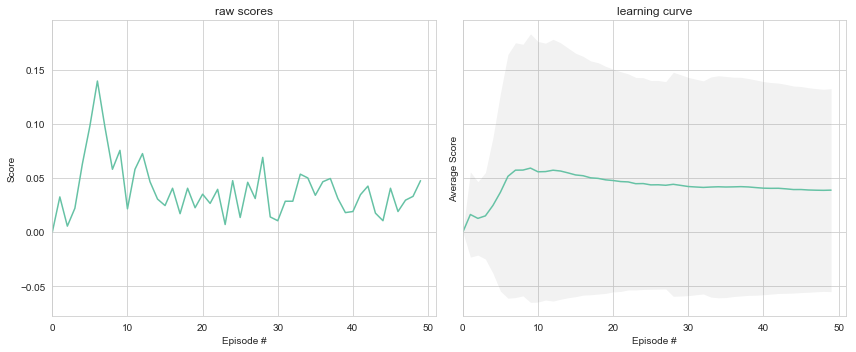

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

#recover data
na_raw = np.array(d_data['scores']).mean(axis=1)
na_mu = np.array(d_data['scores_avg'])
na_sigma = np.array(d_data['scores_std'])

# plot the scores
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# plot the sores by episode
ax1.plot(np.arange(len(na_raw)), na_raw)
ax1.set_xlim(0, len(na_raw)+1)
ax1.set_ylabel('Score')
ax1.set_xlabel('Episode #')
ax1.set_title('raw scores')

# plot the average of these scores
# ax2.axhline(y=30., xmin=0.0, xmax=1.0, color='r', linestyle='--', linewidth=0.7, alpha=0.9)
ax2.plot(np.arange(len(na_mu)), na_mu)
ax2.fill_between(np.arange(len(na_mu)), na_mu+na_sigma, na_mu-na_sigma, facecolor='gray', alpha=0.1)
ax2.set_ylabel('Average Score')
ax2.set_xlabel('Episode #')
ax2.set_title('learning curve')

f.tight_layout()

In [ ]:
f.savefig(fig_prefix + '%s-learning-curve.jpg' % model_prefix, format='jpg')

In [55]:
env.close()

## 5. Conclusion

The Deep Q-learning agent was able to solve the environment in 529 episodes. In the next experiment I will implement and test the Double Deep Q-learning model.